In [1]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
from utils.path import WildcardPath
from utils.enums import ToolEnum, FeatureEnum as FE, FeatureDirectionEnum as FDE, FeatureTypeEnum as FTE
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np

import alignment.ensemble
import alignment.dataset
import utils.plots
from features.pairwise import _CUSTOM_METRICS
from utils.dataloading import load_balibase_results

In [2]:
_, test_feats, *_ = load_balibase_results(
    ["treebase_test_small_v2"], with_reference=False, benchmarking_scores=False
)
# test_feats[["n_sequences", "max_sequence_length"]].isna().mean(axis=0)
test_feats.isna().mean(axis=0).sort_values(ascending=False)

unaligned: (10, 87)
aligned: (70, 195)
confusion: (70, 18)


max_pythia_score            0.028571
mean_pythia_score           0.028571
min_pythia_score            0.028571
std_pythia_score            0.028571
median_pythia_score         0.028571
                              ...   
mean_kmer_similarity_5      0.000000
median_kmer_similarity_5    0.000000
std_kmer_similarity_5       0.000000
min_kmer_similarity_10      0.000000
max_kmer_similarity_10      0.000000
Length: 195, dtype: float64

In [2]:
DATA_DIR = WildcardPath("/hits/fast/cme/bodynems/data/")
RESULT_DIR = WildcardPath("/hits/fast/cme/bodynems/MSA_difficulty/results")

run_suffix = ""
# run_suffix = "_muscle5"
# run_suffix = "_reduced"

BENCHMARKS = ["treebase"]
# BENCHMARKS = ["balibase3/RV11", "balibase3/RV12"]

OUTPUT_DIR = DATA_DIR / "output" / "{benchmark}"
TOOL_DIR = OUTPUT_DIR / "{dataset}" / "{tool}"

DATASETS = OUTPUT_DIR.format(benchmark=BENCHMARKS[0]).listdir(dirs_only=True)
_file_suffix_map = {"": "_multi", "_muscle5": "_muscle5", "_reduced": "_reduced"}
file_suffix = _file_suffix_map[run_suffix]

benchmark_mapping = dict(zip(BENCHMARKS, ["RV11 (hard)", "RV12 (easy)"]))

In [3]:
id_cols = ["benchmark", "dataset", "tool"]
(
    unaligned_features,
    aligned_features,
    aligned_cols,
    reference_features,
    confusion_features,
    _,
    _,
) = load_balibase_results(BENCHMARKS, with_reference=False, benchmarking_scores=False)
aligned_cols = aligned_cols.to_list()

unaligned: (799, 87)
aligned: (5593, 195)
confusion: (5593, 18)


In [5]:
result_df = pd.read_pickle(
    "/hits/fast/cme/bodynems/MSA_difficulty/results/treebase/modeling/2025-05-12_19-55-34_crossval.pkl"
)
print(
    result_df.sort_values("test_neg_root_mean_squared_error", ascending=False)
    .iloc[:1, :0]
    .to_latex()
)

\begin{tabular}{llllll}
\toprule
n_estimators & learning_rate & max_depth & min_samples_leaf & max_features & loss \\
\midrule
2000 & 0.010000 & 8 & 5 & 0.100000 & huber \\
\cline{1-6} \cline{2-6} \cline{3-6} \cline{4-6} \cline{5-6}
\bottomrule
\end{tabular}



In [7]:
pred_feats = [
    # single
    "n_sequences",
    "data_type",
    "sequence_length_ratio",
    "lower_bound_gap_percentage",
    # five-fold
    "sequence_length",
    "shannon_entropy",
    "score_ratio_basic",
    "gap_ratio_basic",
    "stretch_ratio_basic",
    "avg_gap_length_basic",
    "perc_seq_hash_hamming_16bit",
    "kmer_similarity_5",
    "kmer_similarity_10",
    # "seq_length_taxa_ratio",
    # "score_ratio_advanced",
    # "gap_ratio_advanced",
    # "stretch_ratio_advanced",
    # "avg_gap_length_advanced",
]


def feat_filter(columns):
    out = []
    for feat in pred_feats:
        for column in columns:
            if feat in column:
                out.append(column)
    out = list(set(out))
    # out = list(filter(lambda s: "median" not in s, out))
    return out

In [8]:
test_cols = set(unaligned_features.columns).symmetric_difference(
    feat_filter(unaligned_features)
)
# test_cols

In [94]:
from utils.prediction import get_ml_data
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from utils.prediction import METRICS
from sklearn.ensemble import GradientBoostingRegressor
from functools import partial

y_feat = "mean_" + FE.HOMOLOGY_POS_DIST
X, y = get_ml_data(y_feat)
datasets = X.dataset.copy()
data_types = X.data_type.copy()
X = X.drop("dataset", axis=1)


# # # # # Manual feature selection
# aa_mask = X.data_type == 1
# # # # X = X[aa_mask].reset_index(drop=True)
# # # # y = y[aa_mask].reset_index(drop=True)
# # # # datasets = datasets[aa_mask].reset_index(drop=True)
# # # # data_types = data_types[aa_mask].reset_index(drop=True)

pred_cols = feat_filter(X.columns)
X = X[pred_cols]
print("#Feats:", len(pred_cols))


# # # # # Automatic feature selection
# selector = mutual_info_regression
# k = 20
# feat_selector = SelectKBest(selector, k=k).fit(X, y)
# cols_idxs = feat_selector.get_support(indices=True)
# pred_cols = X.columns[cols_idxs].copy()
# X = X[pred_cols]

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.25, stratify=X["data_type"], random_state=0
# )
stratify_col = np.empty_like(y)
dna_mask = X["data_type"] == 0
stratify_col[dna_mask] = pd.qcut(y[dna_mask], 5).factorize()[0]
stratify_col[~dna_mask] = pd.qcut(y[~dna_mask], 5).factorize()[0] + 5
print(stratify_col)
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    stratify=stratify_col,
    # stratify=pd.qcut(y, 10),
    random_state=0,
)

datasets_train = datasets.loc[X_train.index]
datasets_test = datasets.loc[X_test.index]
data_types_train = data_types.loc[X_train.index]
data_types_test = data_types.loc[X_test.index]

X = X.reset_index(drop=True)

unaligned: (799, 87)
aligned: (5593, 195)
confusion: (5593, 18)
Index(['DNA', 'AA'], dtype='object')
#Feats: 49
[0. 0. 1. 2. 3. 5. 6. 6. 1. 0. 0. 0. 7. 8. 8. 9. 3. 4. 1. 0. 6. 0. 1. 2.
 2. 0. 4. 2. 0. 5. 8. 7. 7. 9. 7. 5. 2. 3. 4. 4. 3. 2. 1. 0. 1. 7. 5. 6.
 8. 4. 3. 1. 8. 0. 4. 3. 3. 4. 3. 4. 3. 4. 1. 4. 3. 4. 9. 2. 1. 3. 3. 3.
 4. 5. 2. 4. 0. 1. 2. 0. 5. 4. 3. 0. 1. 4. 2. 1. 2. 8. 6. 8. 7. 1. 1. 8.
 4. 2. 9. 0. 9. 0. 2. 3. 1. 5. 7. 7. 4. 9. 5. 0. 3. 4. 6. 3. 2. 6. 5. 6.
 5. 7. 5. 7. 6. 5. 6. 5. 6. 7. 1. 0. 5. 0. 9. 9. 5. 0. 1. 0. 4. 0. 2. 5.
 1. 7. 3. 8. 9. 6. 3. 1. 2. 0. 0. 4. 2. 4. 3. 3. 3. 7. 1. 1. 3. 1. 7. 7.
 2. 9. 3. 6. 6. 1. 2. 7. 1. 0. 0. 3. 9. 1. 2. 2. 3. 4. 4. 7. 2. 7. 6. 2.
 6. 3. 0. 0. 3. 6. 9. 6. 6. 6. 9. 6. 9. 6. 9. 3. 1. 3. 3. 7. 5. 7. 3. 1.
 2. 0. 3. 2. 6. 9. 0. 4. 5. 5. 4. 6. 6. 6. 4. 0. 7. 0. 0. 4. 3. 5. 7. 9.
 3. 1. 2. 3. 9. 7. 2. 2. 4. 4. 3. 8. 9. 0. 8. 4. 9. 4. 2. 5. 9. 6. 9. 7.
 2. 6. 1. 5. 1. 1. 0. 8. 5. 8. 5. 9. 7. 3. 0. 3. 6. 2. 2. 3. 1. 3. 6. 8.
 7. 5. 9. 3.

In [ ]:
include_bb = False
if include_bb:
    unaligned_bb, aligned_bb, *_ = load_balibase_results(
        [
            "balibase3/RV11",
            "balibase3/RV12",
        ],
        with_reference=False,
    )
    X_bb = unaligned_bb.sort_values(id_cols[:2], ignore_index=True)
    X_bb = X_bb.drop(id_cols[:2], axis=1)
    X_bb["data_type"], data_type_mapping = pd.factorize(unaligned_bb["data_type"])
    X_bb["data_type"] = unaligned_bb["data_type"].map({"DNA": 0, "AA": 1})
    X_bb = X_bb[pred_cols]
    y_bb = (
        aligned_bb.sort_values(id_cols, ignore_index=True)
        .loc[aligned_bb.tool == "all", y_feat]
        .reset_index(drop=True)
    )

    X_train = pd.concat((X_train, X_bb), axis=0, ignore_index=True)
    y_train = pd.concat((y_train, y_bb), ignore_index=True)

unaligned: (162, 87)
aligned: (1134, 205)
confusion: (1134, 18)


In [ ]:
import utils.prediction
from sklearn.ensemble import RandomForestRegressor

best_params = {
    "n_estimators": 100,
    "learning_rate": 0.01,
    "max_depth": 8,
    "min_samples_leaf": 5,
    "max_features": 0.1,
    "loss": "huber",
    # "criterion": "squared_error",
}

# best_params = dict(
#     n_estimators=2000,
#     loss="absolute_error",
#     learning_rate=0.08,
#     max_depth=7,
#     # max_features="sqrt",
#     # min_samples_leaf=3
# )
# weights = 0.01 + y_train**2 / sum(y_train**2)
# weights = None

# n_estimators = [5, 10, 25, 50, 100, 250, 500, 1000, 2000]
n_estimators = [5, 10, 25, 50, 100]
n_estimators = [30]
# n_estimators = [400]
# n_estimators = [0.005, 0.02, 0.04, 0.06, 0.08, 0.1]
n_estimators = np.linspace(5, 2000, 20).astype(int)
# n_estimators = [5, 10, 25, 50, 100]
perf_train_dicts = {}
perf_test_dicts = {}

for n_estimator in n_estimators:
    best_params["n_estimators"] = n_estimator
    model = GradientBoostingRegressor(**best_params).fit(X_train, y_train)
    # model = RandomForestRegressor(n_estimators=n_estimator, oob_score=True).fit(
    #     X_train, y_train, weights
    # )
    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    perf_train_dict = {
        key: val(y_train, y_train_pred, eps=1e-4)
        for key, val in utils.prediction.METRICS.items()
    }
    perf_train_dicts[n_estimator] = perf_train_dict
    perf_test_dict = {
        key: val(y_test, y_pred, eps=1e-4)
        for key, val in utils.prediction.METRICS.items()
    }
    perf_test_dicts[n_estimator] = perf_test_dict
    print(perf_train_dicts[n_estimator]["RMSE"], perf_test_dicts[n_estimator]["RMSE"])

perf_train_df = pd.DataFrame(perf_train_dicts).T
perf_test_df = pd.DataFrame(perf_test_dicts).T
perf_train_df.to_pickle(
    RESULT_DIR / "treebase" / "modeling" / "progression_perf_train.pkl"
)
perf_train_df.to_pickle(
    RESULT_DIR / "treebase" / "modeling" / "progression_perf_test.pkl"
)
print(perf_train_dict[n_estimator]["RMSE"], perf_test_dict[n_estimator]["RMSE"])

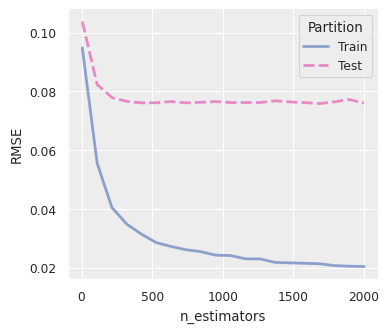

In [ ]:
# perf_train_df = pd.read_pickle(
#     RESULT_DIR / "treebase/modeling/progression_perf_train.pkl"
# )
# perf_test_df = pd.read_pickle(
#     RESULT_DIR / "treebase/modeling/progression_perf_test.pkl"
# )
perf_train_df["Partition"] = "Train"
perf_test_df["Partition"] = "Test"
perf_plot_df = pd.concat((perf_train_df, perf_test_df), axis=0).reset_index()
perf_plot_df = perf_plot_df.rename({"index": "n_estimators"}, axis=1)
# print(perf_plot_df)

fig = plt.figure(figsize=(4, 3.5))
fig.tight_layout()
ax = sn.lineplot(
    perf_plot_df,
    x="n_estimators",
    y="RMSE",
    hue="Partition",
    style="Partition",
    linewidth=2,
    palette=sn.color_palette("Set2")[2:4],
)
# plt.ylim(top=0.105)
# plt.xlim(right=0.1)
fig.savefig(
    RESULT_DIR / "treebase" / "treebase_pred_n_estimators.svg", bbox_inches="tight"
)

\begin{tabular}{llrr}
 &  & RMSE & Correlation \\
Model Variant & Weighted &  &  \\
\multirow[c]{2}{*}{standard} & No & 0.0645 & 0.7346 \\
 & Yes & 0.0672 & 0.7321 \\
\multirow[c]{2}{*}{shifted} & No & 0.0602 & 0.7805 \\
 & Yes & 0.0589 & 0.7840 \\
\end{tabular}


       dataset    y_test    y_pred  residual  residual_abs Data Type
0  19629_0.phy  0.554983  0.212251 -0.342732      0.342732        AA
1  21817_2.phy  0.031603  0.253327  0.221724      0.221724        AA
2  10949_3.phy  0.197122  0.021462 -0.175660      0.175660        AA
3  18990_0.phy  0.624874  0.460082 -0.164792      0.164792        AA
4  20028_0.phy  0.256602  0.093621 -0.162981      0.162981       DNA
5  26169_1.phy  0.181677  0.046864 -0.134812      0.134812       DNA
6  10801_0.phy  0.156081  0.024790 -0.131291      0.131291        AA
7  13876_0.phy  0.219839  0.089170 -0.130669      0.130669       DNA


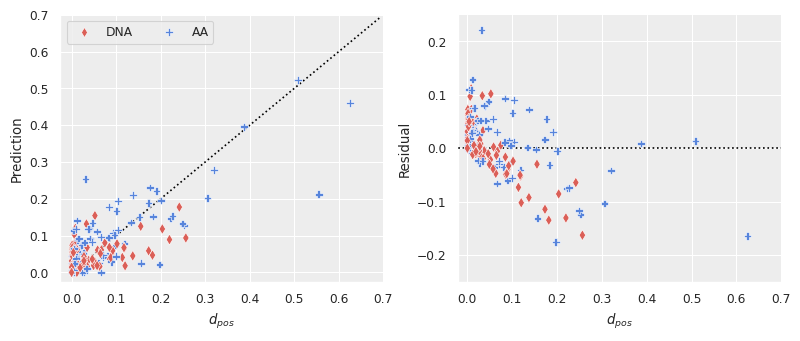

In [ ]:
import utils.prediction
from sklearn.linear_model import LinearRegression

# from importlib import reload
# reload(utils.prediction)

# best_params["n_estimators"] = 400
# model = GradientBoostingRegressor(**best_params).fit(X_train, y_train)
# model = LassoCV(max_iter=5000).fit(X_train, y_train)
eps = 1e-1
weights = 0.01 + y_train / sum(y_train)
# model = LinearRegression().fit(X_train, np.log(y_train + eps))
model = LinearRegression().fit(X_train, y_train, sample_weight=weights)

names = ["base", "base_weighted", "log", "log_weighted"]
names = ["standard", "standard", "shifted", "shifted"]
weighted = ["No", "Yes", "No", "Yes"]

models = [
    LinearRegression().fit(X_train, y_train),
    LinearRegression().fit(X_train, y_train, sample_weight=weights),
    LinearRegression().fit(X_train, np.log(y_train + eps)),
    LinearRegression().fit(X_train, np.log(y_train + eps), sample_weight=weights),
]
pred_funcs = [
    lambda m: np.maximum(m.predict(X_test), 0),
    lambda m: np.maximum(m.predict(X_test), 0),
    lambda m: np.maximum(np.exp(m.predict(X_test)) - eps, 0),
    lambda m: np.maximum(np.exp(m.predict(X_test)) - eps, 0),
]
perf_dicts = []
for model, pred_func in zip(models, pred_funcs):
    y_pred = pred_func(model)
    perf_dict = {
        key: val(y_test, y_pred, eps=1e-4)
        for key, val in utils.prediction.METRICS.items()
    }
    perf_dicts.append(perf_dict)
perf_df = pd.DataFrame(perf_dicts, index=names)
perf_df.index = pd.MultiIndex.from_arrays(
    (names, weighted), names=["Model Variant", "Weighted"]
)

print(
    perf_df.drop(["MAPE", "MAE"], axis=1)
    .rename({"Corr": "Correlation"}, axis=1)
    .style.format(precision=4)
    .to_latex()
)
print()
# print(y_test.describe())
resid_df = datasets_test.to_frame().reset_index(drop=True)
resid_df["y_test"] = y_test.reset_index(drop=True)
resid_df["y_pred"] = y_pred
resid_df["residual"] = resid_df["y_pred"] - resid_df["y_test"]
resid_df["residual_abs"] = resid_df["residual"].abs().copy()
resid_df["Data Type"] = data_types_test.reset_index(drop=True).replace(
    {0: "DNA", 1: "AA"}
)
print(
    resid_df.sort_values("residual_abs", ascending=False, ignore_index=True)
    # .groupby("data_type")
    .head(8)
)

colors = sn.color_palette("hls", 10)
colors = [colors[0], colors[6]]
fig, axes = plt.subplots(ncols=2, figsize=(8, 3.5))
# residuals = residuals.iloc[np.argsort(y_test)]
sn.scatterplot(
    resid_df,
    x="y_test",
    y="y_pred",
    ax=axes[0],
    hue="Data Type",
    style="Data Type",
    markers=["d", "P"],
    s=30,
    palette=colors,
    zorder=5,
    legend=True,
)
# plt.ylabel(feat.pretty)
# plt.xlabel("Prediction")

sn.scatterplot(
    resid_df,
    x=resid_df["y_test"],
    y="residual",
    hue="Data Type",
    style="Data Type",
    markers=["d", "P"],
    s=30,
    palette=colors,
    ax=axes[1],
    zorder=5,
    legend=False,
)
axes[0].plot([0, 0.695], [0, 0.695], linestyle=":", color="black", zorder=3)
axes[1].plot([-0.05, 0.7], [0, 0], linestyle=":", color="black", zorder=3)
axes[0].set_xlim(-0.025, 0.7)
axes[0].set_ylim(-0.025, 0.7)
axes[1].set_xlim(-0.02, 0.7)
axes[1].set_ylim(-0.25, 0.25)
sn.move_legend(axes[0], "upper left", ncols=2, title="")
# plt.xlabel("Prediction")
# axes[0].set_title("Predicted Values")
# axes[1].set_title("Residuals")
axes[0].set_xlabel(FE.HOMOLOGY_POS_DIST.pretty)
axes[1].set_xlabel(FE.HOMOLOGY_POS_DIST.pretty)
axes[0].set_ylabel("Prediction")
axes[1].set_ylabel("Residual")
fig.tight_layout()
fig.savefig(
    RESULT_DIR / "treebase" / "treebase_regression_plot.svg", bbox_inches="tight"
)

In [32]:
resid_df.describe()

,y_test,y_pred,residual,residual_abs
count,200.000000,200.000000,200.000000,200.000000
mean,0.059375,0.058058,-0.001316,0.039082
std,0.097818,0.068924,0.063040,0.049403
min,0.000000,0.000000,-0.273243,0.000000
25%,0.001529,0.014901,-0.011738,0.008254
50%,0.018286,0.034593,0.005617,0.021731
75%,0.073256,0.075726,0.026495,0.049287
max,0.634844,0.466372,0.200039,0.273243


Text(0.5, 0, 'Prediction')

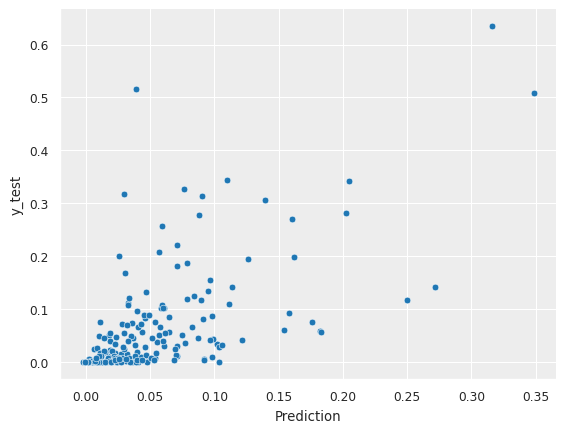

In [ ]:
params = {
    "n_estimators": [2000],
    "learning_rate": [0.1, 0.05, 0.02, 0.01],
    "max_depth": [2, 4, 8],
    "min_samples_leaf": [3, 5, 9, 17],
    "max_features": [1.0, 0.6, 0.3, 0.1],
    "loss": ["squared_error", "absolute_error", "huber"],
}
vals = map(str, params.values())
params = pd.DataFrame(vals, index=params.keys())
params.columns = ["Values"]
print(params.to_latex())